Eager mode: True


Saving content.jpeg to content.jpeg
Saving style.jpg to style.jpg
Files: ['.config', 'content.jpeg', 'style.jpg', 'sample_data']
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1, Step 0, Loss: 16656990.0000
Epoch 1, Step 20, Loss: 8225442.5000
Epoch 1, Step 40, Loss: 4594239.5000
Epoch 1, Step 60, Loss: 3445615.5000
Epoch 1, Step 80, Loss: 2841330.2500
Epoch 2, Step 0, Loss: 2491850.5000
Epoch 2, Step 20, Loss: 2251491.0000
Epoch 2, Step 40, Loss: 2067272.1250
Epoch 2, Step 60, Loss: 1917484.1250
Epoch 2, Step 80, Loss: 1796996.1250
Epoch 3, Step 0, Loss: 1680537.2500
Epoch 3, Step 20, Loss: 1587314.3750
Epoch 3, Step 40, Loss: 1502094.1250
Epoch 3, Step 60, Loss: 1452691.6250
Epoch 3, Step 80, Loss: 1362747.5000
Epoch 4, Step 0, Loss: 1377205.2500
Epoch 4, Step 20, Loss: 1259337.0000
Epoch 4, Step 40, Loss: 1205331.6250
Epoch 4, Step 60, Loss: 1165499.1250
Epoch 4, Step 80, Loss: 1153616.7500
Epoch 5, Step 0, Loss: 1093275.0000
Epoch 5, Step 20, Loss: 1067446.8750
Epoch 5, S

Text(0.5, 1.0, 'Stylized Result')

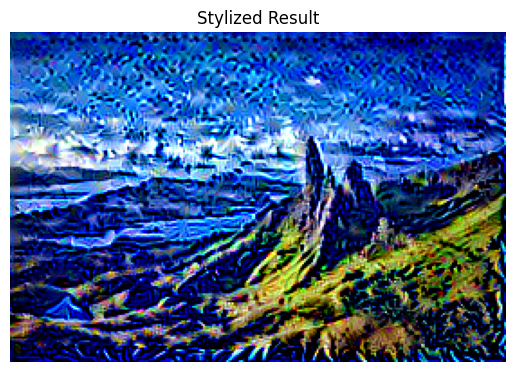

In [1]:
# 1. Install & Setup — Force eager execution
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
print("Eager mode:", tf.executing_eagerly())

# 2. Upload images
from google.colab import files
uploaded = files.upload()
import os
print("Files:", os.listdir())

# 3. Load & preprocess images
from PIL import Image
import numpy as np

def load_and_process(filename, max_dim=512):
    img = Image.open(filename).convert('RGB')
    img.thumbnail((max_dim, max_dim))
    arr = np.array(img).astype(np.float32) / 255.0
    return tf.expand_dims(arr, axis=0)

content_image = load_and_process(next(fname for fname in uploaded if fname.lower().startswith('content')))
style_image = load_and_process(next(fname for fname in uploaded if fname.lower().startswith('style')))

# 4. Build VGG19 model
style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
content_layers = ['block5_conv2']
num_s = len(style_layers)
num_c = len(content_layers)

vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False
outputs = [vgg.get_layer(name).output for name in (style_layers + content_layers)]
model = tf.keras.Model(inputs=vgg.input, outputs=outputs)

# 5. Feature extraction
def gram_matrix(x):
    x = tf.linalg.einsum('bijc,bijd->bcd', x, x)
    n = tf.cast(tf.shape(x)[0]*tf.shape(x)[1]*tf.shape(x)[2], tf.float32)
    return x / n

def preprocess(v):
    return tf.keras.applications.vgg19.preprocess_input(v*255.0)

style_feats = model(preprocess(style_image))[:num_s]
style_feats = [gram_matrix(f) for f in style_feats]
content_feats = model(preprocess(content_image))[num_s:]

# 6. Prepare for training
generated = tf.Variable(content_image, dtype=tf.float32)
opt = tf.keras.optimizers.Adam(learning_rate=0.02)
w_s, w_c = 1e-2, 1e4

# 7. Train step
def train_step():
    with tf.GradientTape() as tape:
        outs = model(preprocess(generated))
        s_outs = outs[:num_s]; c_outs = outs[num_s:]
        sl = tf.add_n([tf.reduce_mean(tf.square(gram_matrix(o)-t))
                       for o,t in zip(s_outs, style_feats)]) * w_s / num_s
        cl = tf.add_n([tf.reduce_mean(tf.square(o-t))
                       for o,t in zip(c_outs, content_feats)]) * w_c / num_c
        loss = sl + cl
    grads = tape.gradient(loss, generated)
    opt.apply_gradients([(grads, generated)])
    generated.assign(tf.clip_by_value(generated,0.0,1.0))
    return loss

# 8. Run training
import time
start = time.time()
epochs=5; steps=100
for e in range(epochs):
  for i in range(steps):
    loss = train_step()
    if i % 20 == 0:
      print(f"Epoch {e+1}, Step {i}, Loss: {loss.numpy():.4f}")
print("Done in", round(time.time()-start,1), "sec")

# 9. Export result
out = generated.numpy().squeeze()
out = (out*255).astype(np.uint8)
Image.fromarray(out).save("stylized.jpg")

import matplotlib.pyplot as plt
plt.imshow(out); plt.axis('off'); plt.title("Stylized Result")
